In [2]:
from datasets import load_dataset

# 1) load dataset
ds = load_dataset("Shunian/kaggle-mbti-cleaned")

# 2) 확인
print(ds)

# 3) pandas로 변환 (필요하면 사용)
df_train = ds["train"].to_pandas()
df_test  = ds["test"].to_pandas()

# 4) CSV 저장
ds["train"].to_csv("train.csv", index=False)
ds["test"].to_csv("test.csv", index=False)

print("Saved: train.csv, test.csv")

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 327828
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 81957
    })
})


Creating CSV from Arrow format: 100%|██████████| 82/82 [00:00<00:00, 509.29ba/s]

Saved: train.csv, test.csv


In [4]:
import pandas as pd

# 파일 경로
train_f = "../NewData/train.csv"
test_f  = "../NewData/test.csv"

# 로드
df_train = pd.read_csv(train_f)
df_test  = pd.read_csv(test_f)

# 매핑 딕셔너리 (네가 준 매핑)
mapping = {
    "ISTJ": 0, "ISFJ": 1, "INFJ": 2, "INTJ": 3,
    "ISTP": 4, "ISFP": 5, "INFP": 6, "INTP": 7,
    "ESTP": 8, "ESFP": 9, "ENFP":10, "ENTP":11,
    "ESTJ":12, "ESFJ":13, "ENFJ":14, "ENTJ":15
}
inv_mapping = {v:k for k,v in mapping.items()}

# 함수: 체크 리포트
def check_df(df, name=""):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Label unique values:", sorted(df['label'].unique()))
    print("Any label outside 0-15?", any(~df['label'].isin(range(16))))
    print("Nulls per column:\n", df.isnull().sum())
    # text 길이 분포
    df['text_len'] = df['text'].astype(str).apply(len)
    print("Text length: min, median, max =", df['text_len'].min(), df['text_len'].median(), df['text_len'].max())
    print("Duplicate rows:", df.duplicated().sum())
    print()

# 체크 실행
check_df(df_train, "Train")
check_df(df_test, "Test")

# 간단하게 레이블 숫자 → 문자열 매핑 추가해서 확인
df_train['mbti_label_str'] = df_train['label'].map(inv_mapping)
print("Some sample labels (train):")
print(df_train[['label','mbti_label_str']].head(10))

--- Train ---
Shape: (327828, 2)
Columns: ['label', 'text']
Label unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
Any label outside 0-15? False
Nulls per column:
 label    0
text     2
dtype: int64
Text length: min, median, max = 3 191.0 263
Duplicate rows: 1847

--- Test ---
Shape: (81957, 2)
Columns: ['label', 'text']
Label unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
Any label outside 0-15? False
Nulls per column:
 label    0
text     0
dtype: int64
Text length: min, median, max = 4 191.0 252
Duplicate rows: 197

Some sample labels (train):
   label mbti_label_str
0      3           INTJ
1     10           ENFP
2      7   

In [2]:
import os
import pandas as pd

DATA_DIR = "../NewData"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

OUT_TRAIN_PATH = os.path.join(DATA_DIR, "train_clean.csv")
OUT_TEST_PATH  = os.path.join(DATA_DIR, "test_clean.csv")

def summarize(df, name):
    print(f"\n--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Label unique values:", df["label"].unique())
    print("Any label outside 0-15?", ~df["label"].between(0, 15).all())
    print("Nulls per column:\n", df.isnull().sum())
    text_len = df["text"].astype(str).str.len()
    print("Text length: min, median, max =",
          text_len.min(), text_len.median(), text_len.max())
    print("Duplicate rows:", df.duplicated().sum())

# 1) 로드
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("===== BEFORE CLEANING =====")
summarize(train, "Train (raw)")
summarize(test,  "Test (raw)")

# 2) 기본 클리닝: text 결측/공백 제거
def clean(df):
    # text가 NaN인 행 제거
    df = df.dropna(subset=["text"])
    # text를 문자열로 변환 후 양쪽 공백 제거
    df["text"] = df["text"].astype(str).str.strip()
    # 빈 문자열("") 제거
    df = df[df["text"] != ""]
    return df

train_clean = clean(train)
test_clean  = clean(test)

# 3) (선택) 중복 제거 – 원하면 주석 해제
train_clean = train_clean.drop_duplicates()
test_clean  = test_clean.drop_duplicates()

print("\n===== AFTER CLEANING =====")
summarize(train_clean, "Train (clean)")
summarize(test_clean,  "Test (clean)")

# 4) 저장
train_clean.to_csv(OUT_TRAIN_PATH, index=False)
test_clean.to_csv(OUT_TEST_PATH, index=False)

print(f"\nSaved cleaned train to: {OUT_TRAIN_PATH}")
print(f"Saved cleaned test  to: {OUT_TEST_PATH}")

# 1. 행 수 감소 확인
#
# 원래 train: 327,828
# clean 후 train: 325,979
#
# → 약 1,849개 제거됨
# → 이것은 딱 NULL + duplicate 제거량이랑 일치함
#
# test도:
# 원래 81,957 → clean 후 81,760
# → 중복 + 공백 무효 텍스트 제거 정상

===== BEFORE CLEANING =====

--- Train (raw) ---
Shape: (327828, 2)
Columns: ['label', 'text']
Label unique values: [ 3 10  7  4  6  2 14 11  9  5  1  0 13  8 15 12]
Any label outside 0-15? False
Nulls per column:
 label    0
text     2
dtype: int64
Text length: min, median, max = 3 191.0 263
Duplicate rows: 1847

--- Test (raw) ---
Shape: (81957, 2)
Columns: ['label', 'text']
Label unique values: [ 5  3  7 13 11  6  4 12 10 15  2  1  0 14  8  9]
Any label outside 0-15? False
Nulls per column:
 label    0
text     0
dtype: int64
Text length: min, median, max = 4 191.0 252
Duplicate rows: 197


/var/folders/2d/tq35hzts01jc3gwbdgfynx4c0000gn/T/ipykernel_1064/2867240045.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].astype(str).str.strip()



===== AFTER CLEANING =====

--- Train (clean) ---
Shape: (325979, 2)
Columns: ['label', 'text']
Label unique values: [ 3 10  7  4  6  2 14 11  9  5  1  0 13  8 15 12]
Any label outside 0-15? False
Nulls per column:
 label    0
text     0
dtype: int64
Text length: min, median, max = 4 191.0 263
Duplicate rows: 0

--- Test (clean) ---
Shape: (81760, 2)
Columns: ['label', 'text']
Label unique values: [ 5  3  7 13 11  6  4 12 10 15  2  1  0 14  8  9]
Any label outside 0-15? False
Nulls per column:
 label    0
text     0
dtype: int64
Text length: min, median, max = 4 191.0 252
Duplicate rows: 0

Saved cleaned train to: ../NewData/train_clean.csv
Saved cleaned test  to: ../NewData/test_clean.csv



총 표본 수 (Total samples): 327,828

MBTI Distribution Summary:
MBTI  Count  Percentage (%)
ISTJ   7639            2.33
ISFJ   6279            1.92
ENFP  25672            7.83
ENTP  26415            8.06
ESTJ   1507            0.46
ESFJ   1631            0.50
ENFJ   7311            2.23
ENTJ   8752            2.67
INFJ  55830           17.03
INTJ  40742           12.43
ISTP  12630            3.85
ISFP   9950            3.04
INFP  69372           21.16
INTP  48976           14.94
ESTP   3391            1.03
ESFP   1731            0.53


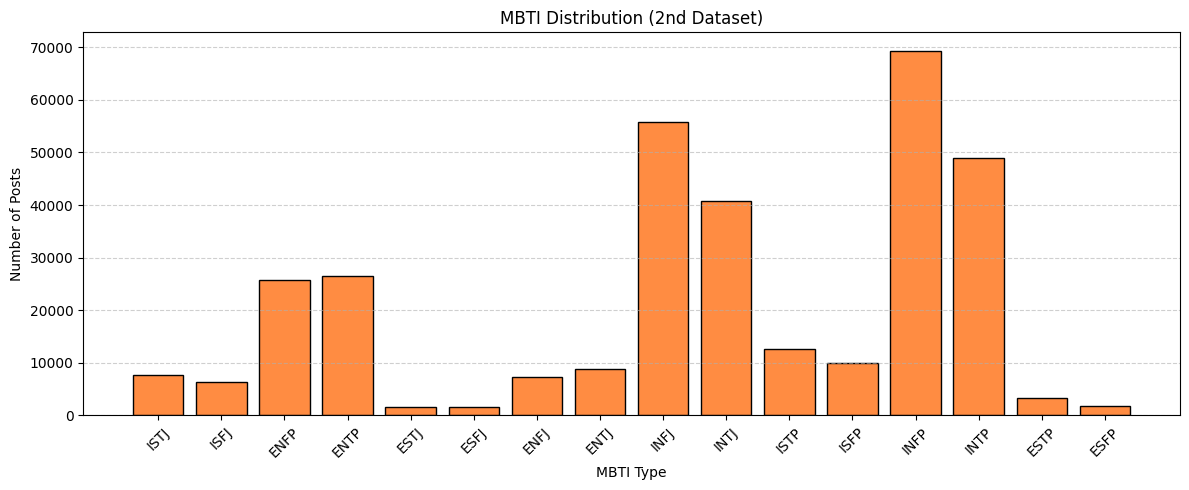

In [1]:
# 새로운 데이터셋 파일 distribution 출력
import os
import matplotlib.pyplot as plt
import pandas as pd

# === 1) 파일 경로 지정 ===
base_dir = "/Users/seojunha/PycharmProjects/MBTI_Prediction/NewData"
fname = "mbti_cleaned_train.csv"
path = os.path.join(base_dir, fname)

# Load + Preprocessing
df = pd.read_csv(path)
df["label"] = df["label"].astype(str).str.upper().str.strip()

# 3) 개수/비율
counts = df["label"].value_counts().sort_index()
percentages = (counts / len(df) * 100).round(2)

# --- 네가 제공한 매핑 ---
idx_to_mbti = {
    "0": "ISTJ", "1": "ISFJ", "2": "INFJ", "3": "INTJ",
    "4": "ISTP", "5": "ISFP", "6": "INFP", "7": "INTP",
    "8": "ESTP", "9": "ESFP", "10": "ENFP", "11": "ENTP",
    "12": "ESTJ", "13": "ESFJ", "14": "ENFJ", "15": "ENTJ"
}

# counts.index 가 문자열 MBTI라면 그대로 사용
# 만약 index가 0~15 라면 매핑 적용
try:
    x_labels = [idx_to_mbti[str(i)] for i in counts.index]
except:
    x_labels = list(counts.index)

# === MBTI 분포 요약 테이블 생성 ===
summary_df = pd.DataFrame({
    "MBTI": x_labels,
    "Count": counts.values,
    "Percentage (%)": percentages.values
})

print(f"\n총 표본 수 (Total samples): {len(df):,}\n")
print("MBTI Distribution Summary:")
print(summary_df.to_string(index=False))

# 5) 시각화
plt.figure(figsize=(12, 5))
plt.bar(range(len(counts)), counts.values, color="#FF8C42", edgecolor="black")
plt.title("MBTI Distribution (2nd Dataset)")
plt.xlabel("MBTI Type")
plt.ylabel("Number of Posts")

plt.xticks(ticks=range(len(counts)), labels=x_labels, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [6]:
import os
import re
import pandas as pd

base_dir = "/Users/seojunha/PycharmProjects/MBTI_Prediction/NewData"
files = ["mbti_test.csv", "mbti_train.csv"]  # 실제 파일명 맞춰 사용

idx_to_mbti = {
    "0": "ISTJ", "1": "ISFJ", "2": "INFJ", "3": "INTJ",
    "4": "ISTP", "5": "ISFP", "6": "INFP", "7": "INTP",
    "8": "ESTP", "9": "ESFP", "10": "ENFP", "11": "ENTP",
    "12": "ESTJ", "13": "ESFJ", "14": "ENFJ", "15": "ENTJ"
}

mbti_order = [
    "ISTJ","ISFJ","INFJ","INTJ",
    "ISTP","ISFP","INFP","INTP",
    "ESTP","ESFP","ENFP","ENTP",
    "ESTJ","ESFJ","ENFJ","ENTJ"
]

def normalize_label(v):
    s = str(v).strip().upper()
    s = re.sub(r"\.0$", "", s)   # '14.0' -> '14'

    if s.isdigit() and s in idx_to_mbti:
        return idx_to_mbti[s]

    return s

# === 🔹 train + test 라벨 전부 모으기 ===
all_labels = []

for fname in files:
    path = os.path.join(base_dir, fname)
    df = pd.read_csv(path)

    df["label_norm"] = df["label"].apply(normalize_label)
    all_labels.append(df["label_norm"])

# 하나의 Series로 결합
all_labels = pd.concat(all_labels, ignore_index=True)

# 혹시 이상 라벨이 섞였는지 최종 점검
unknown = sorted(set(all_labels) - set(mbti_order))
if unknown:
    print("⚠️ MBTI 16개 외 라벨 발견:", unknown)

# === 🔹 16개 MBTI 고정 출력 ===
counts = all_labels.value_counts().reindex(mbti_order, fill_value=0)
total = int(counts.sum())
percentages = (counts / total * 100).round(2)

summary_df = pd.DataFrame({
    "MBTI": mbti_order,
    "Count": counts.values,
    "Percentage (%)": percentages.values
})

print("\n=== Combined Train + Test MBTI Distribution ===")
print(f"Total samples: {total:,}")
print(summary_df.to_string(index=False))


=== Combined Train + Test MBTI Distribution ===
Total samples: 409,785
MBTI  Count  Percentage (%)
ISTJ   9601            2.34
ISFJ   7846            1.91
INFJ  69842           17.04
INTJ  50943           12.43
ISTP  15878            3.87
ISFP  12428            3.03
INFP  86678           21.15
INTP  61261           14.95
ESTP   4214            1.03
ESFP   2137            0.52
ENFP  32015            7.81
ENTP  32988            8.05
ESTJ   1871            0.46
ESFJ   1995            0.49
ENFJ   9102            2.22
ENTJ  10986            2.68
